In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.spatial.transform import Rotation as Rot

In [ ]:
# #Read landmarks and cameras from bal format

# with open('/Data/gautt/bundle_adjustment/robust_povar/data_custom/problem-49-7776-pre.txt', 'r') as file:
#     cam_nb, lm_nb, tot = file.readline().strip().split()
#     cam_nb = int(cam_nb); lm_nb = int(lm_nb); tot = int(tot)
#     obs = {}
#     camera_parameters = np.zeros((cam_nb, 15), dtype=np.float64)
#     landmarks = np.zeros((lm_nb, 3), dtype=np.float64)
#     for idx,line in enumerate(file):
#         if idx < tot:
#             line = line.strip().split()
#             cam_id, lm_id, x, y = line
#             cam_id = int(cam_id); lm_id = int(lm_id); x = float(x); y = float(y)
#             obs[(cam_id, lm_id)] = (x, y)
#             # print(len(line))

#         elif idx < tot + 15 * cam_nb:
#             q, r = divmod(idx - tot, 15)
#             camera_parameters[q, r] = float(line.strip())
        
#         else:
#             q, r = divmod(idx - tot - 15 * cam_nb, 3)
#             landmarks[q, r] = float(line.strip())
        

In [ ]:
# u_x_list = [value[0] for value in obs.values()]
# u_y_list = [value[1] for value in obs.values()]

# min_u_x = min(u_x_list)
# max_u_x = max(u_x_list)
# min_u_y = min(u_y_list)
# max_u_y = max(u_y_list)

# print(
#     f"min_u_x: {min_u_x}, max_u_x: {max_u_x}, min_u_y: {min_u_y}, max_u_y: {max_u_y}"
# )

In [ ]:
class ProjectionMixin:
    def project_no_clipping(self):
        """ Project landmarks onto the image plane of each camera.
            All projections are kept (sensor size is infinite at this point and there is complete transparency).

        Returns:
            projections (ndarray(n, m, 2)): Projections of the landmarks onto the image plane of each camera.
        """

        projections = np.zeros((self.cam_nb, self.lm_nb, 2), dtype=np.float64)
        for i in range(self.cam_nb):
            projection = np.einsum('ij,mj->mi', self.projection_matrices[i], self.landmarks)
            projections[i] = projection[:, :2] / projection[:, 2][:, np.newaxis]
        return projections
    
    def get_observations_Zbuffered(self, buffering_pixel_nb=(640, 480), buffer_tolerance = 0.05, show_lm_per_pixel_dist = []):
        """Project landmarks onto the image sensor of each camera. Only the observation on the sensors are kept.
            If 2 points land in the same "buffering_pixel" and are far away in the scene, we keep the closest one. A method inspired by z-buffering is used for that matter.

        Args:
            buffering_pixel_nb (tuple, optional): Number of pixels used for the Z-buffering. Defaults to (640, 480).
            buffer_tolerance (float, optional) : Tolerance ratio of depth within a pixel beyond which far-away points are eliminated. Defaults to 0.05.
            show_lm_per_pixel_dist (list of indices, optionale) : display the distributioon of the number of lm per pixel for the given camera indices after the hidden surface removal.
                                                                    Use it to calibrate the Z-buffering.

        Returns:
            projections (ndarrau(n, m, 2)) : list of observations, with NaN values when no observation is made.
        """

        landmarks_in_camera_coordinates = np.einsum('nij,mj->nmi', self.extrinsics, self.landmarks)
        projections = np.zeros((self.cam_nb, self.lm_nb, 2), dtype=np.float64)
        pixel_projections = np.zeros((self.cam_nb, self.lm_nb, 2), dtype=np.int16)
        for i in range(self.cam_nb):
            projection = np.einsum('ij,mj->mi', self.intrinsics[i], landmarks_in_camera_coordinates[i])
            projections[i] = projection[:, :2] / projection[:, 2][:, np.newaxis]

        # For each camera, we look on which buffer pixel the projection lands
        width_pixel, height_pixel = buffering_pixel_nb
        width_sensors = self.sensor_sizes[:, 0][:, np.newaxis]
        height_sensors =  self.sensor_sizes[:, 1][:, np.newaxis]

        scale_x = width_pixel / width_sensors
        scale_y = height_pixel / height_sensors

        x_pixel_array = (projections[:, :, 0] + width_sensors / 2) * scale_x
        y_pixel_array = (projections[:, :, 1] + height_sensors / 2) * scale_y

        x_pixel_array = np.round(x_pixel_array).astype(np.int16)
        y_pixel_array = np.round(y_pixel_array).astype(np.int16)

        # Place NaN wherever the projection lands outside of the sensor
        x_mask = (x_pixel_array >= 0) & (x_pixel_array < width_pixel)
        y_mask = (y_pixel_array >= 0) & (y_pixel_array < height_pixel)
        mask = x_mask & y_mask
        projections[~mask] = np.nan

        # Store the pixel coordinate of each landmark in each camera. Place -1 when the point is not valid
        pixel_projections[:, :, 0] = np.where(mask, x_pixel_array, -1)
        pixel_projections[:, :, 1] = np.where(mask, y_pixel_array,  -1)

        z_buffer = np.full((self.cam_nb, width_pixel, height_pixel), np.inf, dtype=np.float64)
        lm_per_pixel_count = np.full((self.cam_nb, width_pixel, height_pixel), 0, dtype=np.int16)

        for cam_idx in range(self.cam_nb):
            for lm_idx in range(self.lm_nb):
                x_pixel, y_pixel = pixel_projections[cam_idx, lm_idx]
                if x_pixel == -1 or y_pixel == -1:
                    continue
                z = landmarks_in_camera_coordinates[cam_idx, lm_idx, 2]
                if z < z_buffer[cam_idx, x_pixel, y_pixel]:
                    z_buffer[cam_idx, x_pixel, y_pixel] = z

        for cam_idx in range(self.cam_nb):
            for lm_idx in range(self.lm_nb):
                x_pixel, y_pixel = pixel_projections[cam_idx, lm_idx]
                if x_pixel == -1 or y_pixel == -1:
                    continue
                z = landmarks_in_camera_coordinates[cam_idx, lm_idx, 2]
                if z > (1 + buffer_tolerance) * z_buffer[cam_idx, x_pixel, y_pixel]:
                    projections[cam_idx][lm_idx][0] = np.nan
                    projections[cam_idx][lm_idx][1] = np.nan
                else:
                    lm_per_pixel_count[cam_idx, x_pixel, y_pixel] += 1


        if len(show_lm_per_pixel_dist) != 0:
            plt.figure(figsize=(10, 6))
            for cam_idx in show_lm_per_pixel_dist:
                flattened_count = lm_per_pixel_count[cam_idx].flatten()
                plt.hist(flattened_count,
                    bins=np.arange(flattened_count.max() + 2) - 0.5,
                    alpha=0.5,
                    label=f'Camera {cam_idx}',
                    histtype='stepfilled',
                    density=True)
            plt.xlabel("Number of landmark points per pixel")
            plt.ylabel("Number of pixels")
            plt.title("Distribution of Landmark Points per Pixel per Camera")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.ylim(0,0.2)
            plt.show()
        self.observations = projections
        return projections

class ExportMixin:
    def export_projections(projections, path):
        cam_nb = projections.shape[0]
        lm_nb = projections.shape[1]
        obs_nb = 0

        for lm_idx in range(lm_nb):
            for cam_idx in range(lm_nb):
                if not (np.isnan(projections[cam_idx][lm_idx][0]) | np.isnan(projections[cam_idx][lm_idx][1])):
                    obs_nb += 1

        with open(path, 'w') as f:
            f.write(f"{cam_nb} {lm_nb} {obs_nb}")
            for lm_idx in range(lm_nb):
                for cam_idx in range(lm_nb):
                    projection = projections[cam_idx][lm_idx]
                    if not (np.isnan(projection[0]) | np.isnan(projection[1])):
                        f.write(f"{cam_nb} {lm_nb} {projection[0]} {projection[1]}")
            
            for cam_idx in range(cam_nb):
                print("do something")


class VisualizationMixin:
    @staticmethod
    def create_camera_object(scale=1, cam_to_world=None):
        # Camera body (box)
        body = o3d.geometry.TriangleMesh.create_box(width=2*scale, height=scale, depth=scale)
        body.translate([-scale, -0.5*scale, -0.5*scale])
        body.paint_uniform_color([0.1, 0.1, 0.1])  # dark gray

        # Camera lens (cone)
        lens = o3d.geometry.TriangleMesh.create_cone(radius=0.5*scale, height=2*scale)
        lens.rotate(o3d.geometry.get_rotation_matrix_from_xyz([0, -np.pi/2, 0]))
        lens.translate([1.8 * scale, 0, 0])
        lens.paint_uniform_color([0.1, 0.1, 0.1])  # dark gray

        # Combine
        camera = body + lens
        camera.rotate(o3d.geometry.get_rotation_matrix_from_xyz([0, - np.pi / 2, 0]))
        camera.translate(-camera.get_center())
        camera.compute_vertex_normals()

        if cam_to_world is not None:
            cam_to_world_h = np.eye(4)
            cam_to_world_h[:3, :4] = cam_to_world
            camera.transform(cam_to_world_h)
        return camera
    
    def visualize_cameras_2d(self, plane='xy', scale=0.1):
        """
        Visualizes camera positions, orientations, and o3D landmark points in 2D.
        
        Parameters:

        - plane: str, 'xy', 'xz', or 'yz' to choose the projection plane.
        - scale: float, length of the direction arrow.
        """
        assert plane in ['xy', 'xz', 'yz'], "Plane must be 'xy', 'xz', or 'yz'"
        
        fig, ax = plt.subplots()
        ax.set_aspect('equal')

        for i, pose in enumerate(self.cam_to_world):
            R = pose[:, :3]
            t = pose[:, 3]

            if plane == 'xy':
                pos = t[[0, 1]]
                direction = R[[0, 1], 2]
            elif plane == 'xz':
                pos = t[[0, 2]]
                direction = R[[0, 2], 2]
            elif plane == 'yz':
                pos = t[[1, 2]]
                direction = R[[1, 2], 2]

            ax.plot(pos[0], pos[1], 'bo')
            ax.arrow(pos[0], pos[1],
                    scale * direction[0], scale * direction[1],
                    head_width=scale * 0.3, head_length=scale * 0.5, fc='r', ec='r')

            # Add index label slightly above the camera position
            ax.text(pos[0], pos[1] + scale * 0.5, str(i), color='blue', fontsize=9, ha='center')


        if plane == 'xy':
            points = self.landmarks[:, [0, 1]]
        elif plane == 'xz':
            points = self.landmarks[:, [0, 2]]
        elif plane == 'yz':
            points = self.landmarks[:, [1, 2]]
            
        ax.plot(points[:, 0], points[:, 1], 'k.', label='Landmarks')

        ax.set_title(f"Camera_positions and landmarks in {plane.upper()} plane")
        ax.grid(True)
        plt.xlabel(plane[0].upper())
        plt.ylabel(plane[1].upper())
        ax.legend()
        plt.show()

    def visualize_3D(self):
        to_display = [self.pcd]
        for cam in self.cam_to_world:
            to_display.append(self.create_camera_object(1, cam))
        o3d.visualization.draw_geometries(to_display)
        

    def visualize_projections(self, projections, show_which_cam=None, sphere_size = 10, fig_size = 5, show_grid = False):
        """
        Visualizes 2D projections from multiple camera views.

        Parameters:
        - projections (ndarray(n,m, 2)) : can contain NaN
        - show_which_cam: list of int or None
            Indices of the cameras to show. If None, all cameras will be shown.
        """
        if show_which_cam is None:
            show_which_cam = list(range(len(projections)))

        widths = self.sensor_sizes[:,0]
        heights = self.sensor_sizes[:,1]
        xlim = np.column_stack((-widths / 2, widths / 2))
        ylim = np.column_stack((-heights / 2, heights / 2))

        n_views = len(show_which_cam)
        fig, axes = plt.subplots(1, n_views, figsize=(fig_size * n_views, fig_size))

        if n_views == 1:
            axes = [axes]

        for ax, cam_idx in zip(axes, show_which_cam):
            proj = projections[cam_idx, :, :]
            if proj.shape[1] != 2:
                raise ValueError(f"Projection at index {cam_idx} must be of shape (N, 2), got {proj.shape}")

            if self.colors is not None:
                if len(self.colors) != proj.shape[0]:
                    raise TypeError("Mismatch of color matrices and projection matrix")
                ax.scatter(proj[:, 0], proj[:, 1], s=sphere_size, c=self.colors)
            else:
                ax.scatter(proj[:, 0], proj[:, 1], s=sphere_size)
            ax.set_xlim(xlim[cam_idx])
            ax.set_ylim(ylim[cam_idx][::-1])  # Invert y-axis so origin is at the center-top
            ax.set_title(f"Camera {cam_idx}")
            ax.set_aspect('equal')
            ax.grid(show_grid)

        plt.tight_layout()
        plt.show()

In [ ]:
class ToyModel(ProjectionMixin, ExportMixin, VisualizationMixin):
    def __init__(self, landmarks, intrinsics, sensor_sizes = [36,24], extrinsics = None, cam_to_world = None, colors = None):
        """Stores all the necessary information of a ToyModel for SfM testing

        Args:
            landmarks (ArrayLike(m,4)) : should be in homogeneous form
            intrinsics (ArrayLike(n, 3, 3) or ArrayLike(3, 3)) : intrinsic matrices. If one is given, it used across all cameras
            sensor_sizes (ArrayLike(n, 2) or ArrayLike(2)) : Size of the sensors : must use the same scale as intrinsic matrices. Defauts to full-frame (36, 24)
            extrinsics (ArrayLike(n, 3, 4), optional): world_to_cam pose matrices. If not defined, cam_to_world must be.
            cam_to_world (_type_, optional) : _description_. cam_to_world pose matrices. If not defined, world_to_cam must be.
            colors (ArrayLike(m, 3), optional) : The colors of the different landmarks

        """
        self.landmarks = np.asarray(landmarks)
        self.intrinsics = np.asarray(intrinsics)
        self.sensor_sizes = np.asarray(sensor_sizes)
        self.colors = colors
        self.observations = None

        if extrinsics is None:
            if cam_to_world is None:
                raise ValueError("At least one of cam_to_world or extrinsics must be declared")
            else:

                self.cam_to_world = np.asarray(cam_to_world)
                self.extrinsics = np.zeros((self.cam_to_world.shape[0], 3, 4))
                self.extrinsics[:, :, :3] = self.cam_to_world[:, :, :3].transpose(0, 2, 1)
                self.extrinsics[:, :, 3] = - np.einsum('ijk,ik->ij', self.extrinsics[:, :, :3], self.cam_to_world[:, :, 3])
                
        else:
            self.extrinsics = np.asarray(extrinsics)
            self.cam_to_world = np.zeros((self.extrinsics.shape[0], 3, 4))
            self.cam_to_world[:, :, :3] = self.extrinsics[:, :, :3].transpose(0, 2, 1)
            self.cam_to_world[:, :, 3] = - np.einsum('ijk,ik->ij', self.cam_to_world[:, :, :3], self.extrinsics[:, :, 3])

        self.lm_nb = self.landmarks.shape[0]
        self.cam_nb = self.extrinsics.shape[0]

        if self.intrinsics.ndim == 2:
            self.intrinsics = np.tile(self.intrinsics, (self.cam_nb, 1, 1))
        elif self.intrinsics.shape[0] != self.cam_nb:
            raise TypeError("Intrinsics and Extrinsics aren't of the same shape")
        
        if self.sensor_sizes.ndim == 1:
            self.sensor_sizes = np.tile(self.sensor_sizes, (self.cam_nb, 1))
        elif self.sensor_sizes.shape[0] != self.cam_nb:
            raise TypeError("Intrinsics and SensorSizes aren't of the same shape")
        
        if self.colors is not None:
            self.colors = np.asarray(self.colors)
            if self.colors.shape[0] != self.lm_nb:
                raise TypeError("Number of colors should be the same as the number of landmarks")

        self.projection_matrices = np.einsum('nij,njk->nik', self.intrinsics, self.extrinsics)

        cartesian_landmarks = self.landmarks[:, :3] / self.landmarks[:, 3][:, np.newaxis]
        self.pcd = o3d.geometry.PointCloud()
        self.points = o3d.utility.Vector3dVector(cartesian_landmarks)

class ToyModel_From_PointCloud(ToyModel):
    def __init__(self, pcd, intrinsics, sensor_sizes = [36,24], extrinsics = None, cam_to_world = None):
        inhomogeneous_landmarks = np.asarray(pcd.points)
        ones = np.ones((inhomogeneous_landmarks.shape[0],1))
        homogeneous_landmarks = np.hstack((inhomogeneous_landmarks, ones))
        super().__init__(landmarks=homogeneous_landmarks, intrinsics=intrinsics, sensor_sizes=sensor_sizes, extrinsics=extrinsics, cam_to_world=cam_to_world, colors=pcd.colors)
        self.pcd = pcd

    def remove_occlusions_and_downsample(self, buffering_pixel_nb=(640, 480), buffer_tolerance = 0.05, show_lm_per_pixel_dist = [], voxel_size=0.02):
        observations = self.get_observations_Zbuffered(buffering_pixel_nb, buffer_tolerance, show_lm_per_pixel_dist)

        _ , _ , indices = self.pcd.voxel_down_sample_and_trace(
            voxel_size=0.2,
            min_bound=self.pcd.get_min_bound(),
            max_bound=self.pcd.get_max_bound()
)
        
        post_down_sampling_indices = [i[0] for i in indices if len(i) > 0]
        self.pcd = self.pcd.select_by_index(post_down_sampling_indices)

        self.observations = observations[:, post_down_sampling_indices, :]

        inhomogeneous_landmarks = np.asarray(self.pcd.points)
        self.colors = self.pcd.colors
        ones = np.ones((inhomogeneous_landmarks.shape[0],1))
        landmarks_homogeneous = np.hstack((inhomogeneous_landmarks, ones))
        self.landmarks = landmarks_homogeneous
        self.lm_nb = self.landmarks.shape[0]

        print("ToyDataset now contains {self.lm_nb} landmarks")
        print("Observations obtained after downsampling and hidden points removal stored in self.observations")

        
        return self.observations
    
class ToyModel_From_SavedNPZ(ToyModel):
    def __init__(self, filename):
        data = np.load(filename, allow_pickle=True)
        landmarks = data['landmarks']
        intrinsics = data['intrinsics']
        extrinsics = data['extrinsics']
        sensor_sizes = data['sensor_sizes']
        colors = data['colors'] if data['colors'].size > 0 else None
        observations = data['observations'] if data['observations'].size > 0 else None

        super().__init__(
            landmarks=landmarks,
            intrinsics=intrinsics,
            extrinsics=extrinsics,
            sensor_sizes=sensor_sizes,
            colors=colors
        )

In [9]:
def camera_positions_arccircle(radial_range = np.pi/4, radial_offset = 0, radius = 1, cam_nb = 10, center = [0, 0, 0], radius_noise_stddev = 0, translation_noise_stddev = 0, rotation_angle_noise_stddev = 0):
    """Create an arccircle of cameras pointing towards the center.
    BEWARE : it is not the extrinsics matrix, but the camera positions and orientations in the world frame

    Args:
        radial_range (float): the actual range of the arc in radians
        radial_offset (float): move the arc along the circle.
        radius (float)
        cam_nb (int)
        center (list): where the cameras point to.
        radius_noise_stddev (flaot): effective radius to center of each camera differ by a gaussian noise multiplicator
        translation_noise_stddev(float): camera positions differ from theoretical arccircle by a gaussian noise
        rotation_angle_noise_stddev(float): camera orientation differ from looking at the center by a gaussian noise on the angles


    Returns:
        cam_to_world (ndarray of shape (cam_nb, 3, 4)). The first three rows are the rotation matrix defining camera orientation,
                                                the last row is the position of the camera in the world frame in inhomogeneous coordinates.
    """
    center = np.array(center, dtype=np.float64)
    cam_to_world = np.zeros((cam_nb,3, 4), dtype=np.float64)
    angles = np.linspace(radial_offset-radial_range/2, radial_offset+radial_range/2, cam_nb)
    for i in range(cam_nb):
        theta = angles[i]
        R = np.array([
            [-np.sin(theta), 0, -np.cos(theta)],
            [np.cos(theta), 0, -np.sin(theta)],
            [0, -1, 0]
            ])
        if rotation_angle_noise_stddev > 0:
            random_axis = np.random.normal(size=3)
            random_axis /= np.linalg.norm(random_axis)
            random_angle = np.random.normal(scale=rotation_angle_noise_stddev)
            noise_rotation = Rot.from_rotvec(random_axis * random_angle).as_matrix(
            )
            R =  noise_rotation @ R
        if radius_noise_stddev > 0:
            radius_noise = np.random.normal(scale=radius_noise_stddev)
        else:
            radius_noise = 0
        t = np.array([
            radius*(1 + radius_noise)*np.cos(theta) + center[0],
            radius*(1 + radius_noise)*np.sin(theta) + center[1],
            center[2],
        ])
        if translation_noise_stddev > 0:
            t += np.random.normal(scale=translation_noise_stddev, size=3)

        cam_to_world[i] = np.hstack([R, t.reshape(3, 1)])
    return cam_to_world

def gaussian_landmarks_homogeneous(centers, stddevs, num_points):
    landmarks = []
    for center, stddev in zip(centers, stddevs):
        x = np.random.normal(center[0], stddev[0], num_points)
        y = np.random.normal(center[1], stddev[1], num_points)
        z = np.random.normal(center[2], stddev[2], num_points)
        ones = np.ones(num_points)
        landmarks.append(np.column_stack((x, y, z, ones)))
    return np.vstack(landmarks)

def lognormal_focal_length_generator(cam_nb, mean, sigma, show_distribution):
    
    focal_lengths = np.random.lognormal(mean, sigma, cam_nb)
    intrinsics = np.array([[
        [focal_lengths[i], 0, 0],
        [0, focal_lengths[i], 0],
        [0, 0, 1]
    ] for i in range(cam_nb)])

    if show_distribution:
        plt.hist(focal_lengths, bins=20, edgecolor='black')
        plt.title('Lognormal Distribution of Focal Lengths')
        plt.xlabel('Focal Length')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    return intrinsics

In [10]:
def get_visualiser_camera_parameters(pcd):
    """Navigate to a camera position of you liking and then close the window to get the camera position of the camera you were looking at the scene with

    Args:
        pcd : Point Cloud

    Returns:
        ndarray(3,3), ndarray(3,4) : Camera intrinsics & Camera position and orientation
    """

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    vis.run()

    view_control = vis.get_view_control()

    camera_parameters = view_control.convert_to_pinhole_camera_parameters()
    cam_to_world = np.linalg.inv(camera_parameters.extrinsic)[:3,:]
    intrinsics = camera_parameters.intrinsic.intrinsic_matrix
    print("Camera position and orientation (camera_to_world):")
    print(cam_to_world)

    print("Camera Intrinsic matrix:")
    print(intrinsics)

    camera_translation = cam_to_world[:, 3]
    print("Camera position:", camera_translation)

    vis.destroy_window()

    return intrinsics, cam_to_world

def load_pcd(file_path, voxel_size=0.01):
    pcd = o3d.io.read_point_cloud(file_path)
    downpcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    return downpcd

def visualize_pcd(pcd):
    # Load the .ply file
    print(pcd)
    o3d.visualization.draw_geometries([pcd])

In [11]:
downpcd = load_pcd('Courthouse.ply', 0.025)

In [6]:
print(len(downpcd.points))

NameError: name 'downpcd' is not defined

In [8]:
_ , cam_to_world = get_visualiser_camera_parameters(downpcd)

Camera position and orientation (camera_to_world):
[[-8.26668394e-01 -1.55461107e-01 -5.40787583e-01  5.89741052e+01]
 [ 5.62670248e-01 -2.36316540e-01 -7.92184755e-01 -6.29923141e+00]
 [-4.64313139e-03 -9.59159182e-01  2.82828755e-01 -2.24185548e+01]]
Camera Intrinsic matrix:
[[935.30743609   0.         959.5       ]
 [  0.         935.30743609 539.5       ]
 [  0.           0.           1.        ]]
Camera position: [ 58.9741052   -6.29923141 -22.41855479]


In [ ]:
o3d.visualization.draw_geometries([downpcd])

In [8]:
cam_positions = np.array([cam_to_world])
landmarks = np.asarray(downpcd.points)
colors = downpcd.colors
ones = np.ones((landmarks.shape[0],1))
landmarks_homogeneous = np.hstack((landmarks, ones))
intrinsics = np.array([[18, 0, 0], [0, 18, 0], [0, 0, 1]], dtype=np.float64)

courthouse_model = ToyModel(landmarks = landmarks_homogeneous, intrinsics=intrinsics, cam_to_world=cam_positions, colors=colors)

projections = courthouse_model.project_no_clipping()

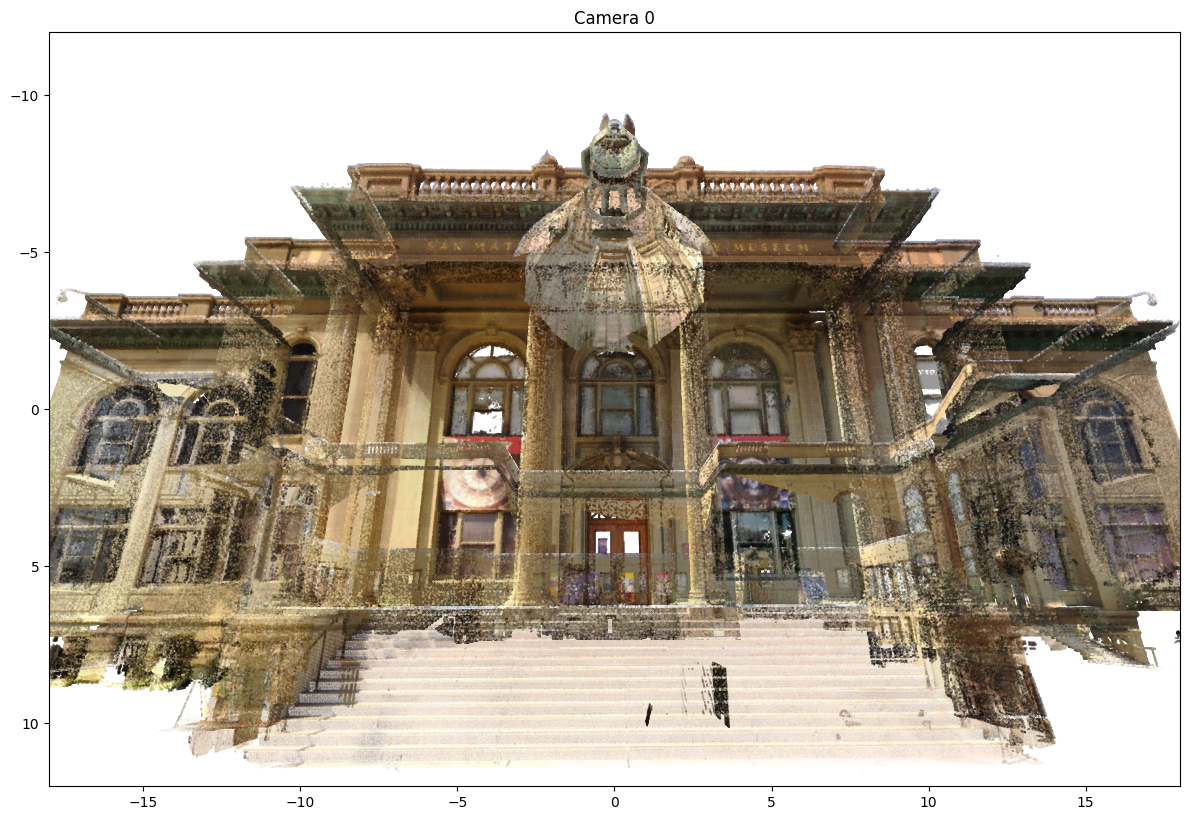

In [11]:
courthouse_model.visualize_projections(projections,sphere_size=0.03, fig_size=12)

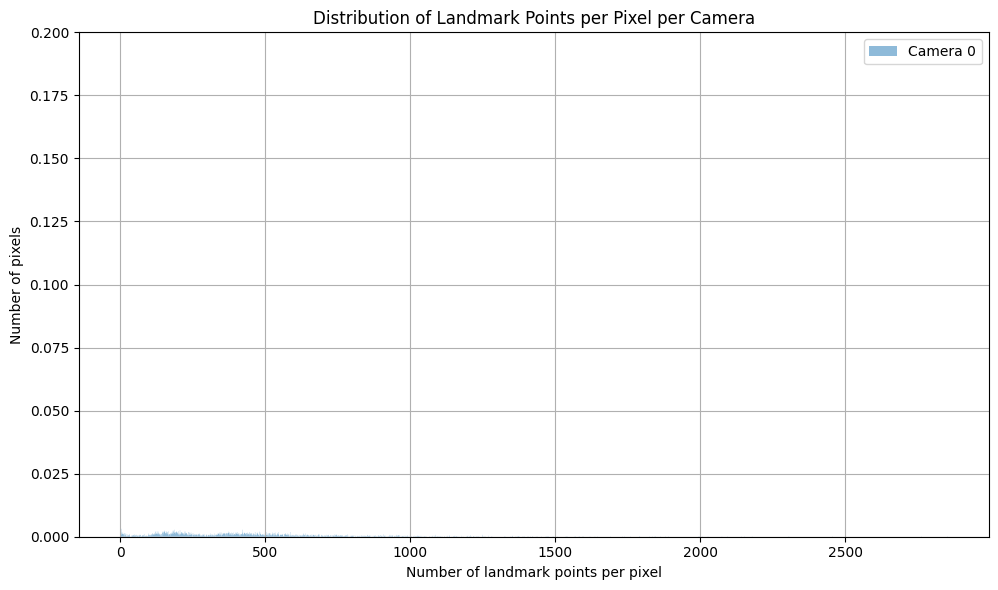

In [12]:
observations = courthouse_model.get_observations_Zbuffered(buffering_pixel_nb=(90,60), show_lm_per_pixel_dist=[0])


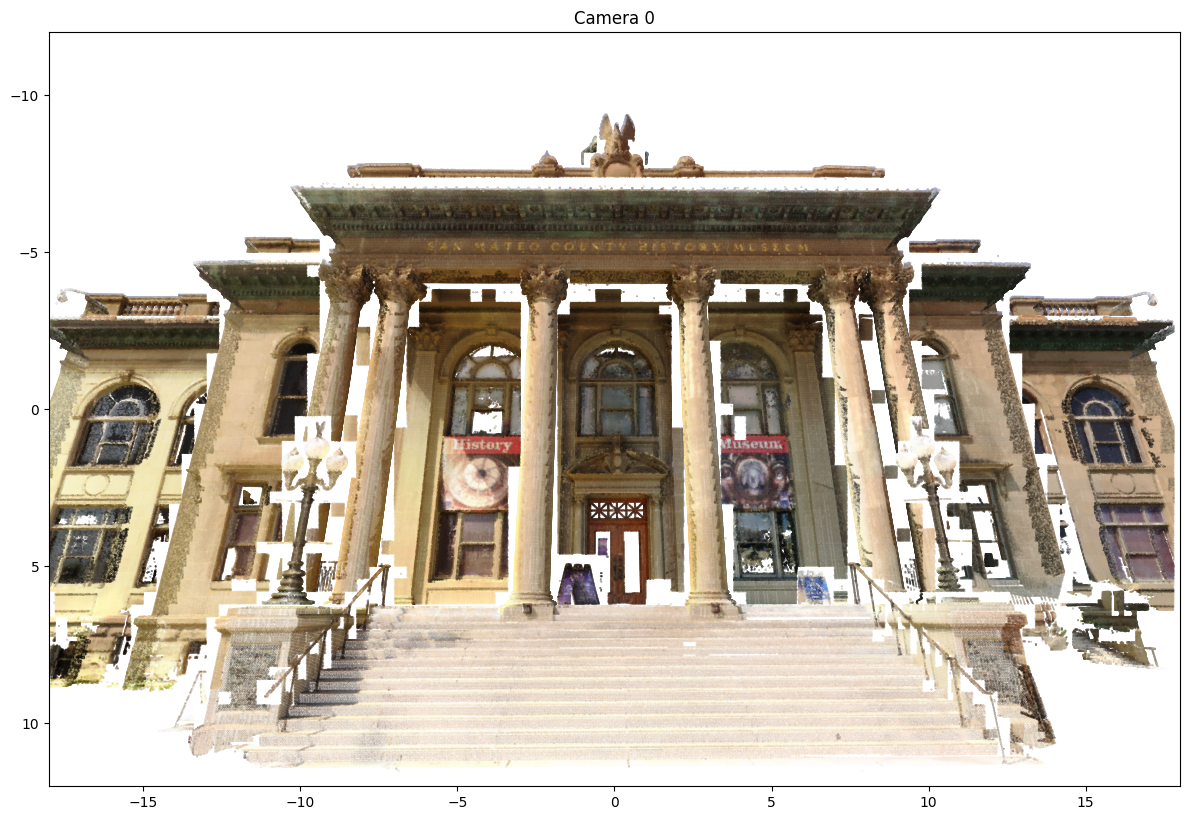

In [16]:
courthouse_model.visualize_projections(observations,sphere_size=0.03, fig_size=12)

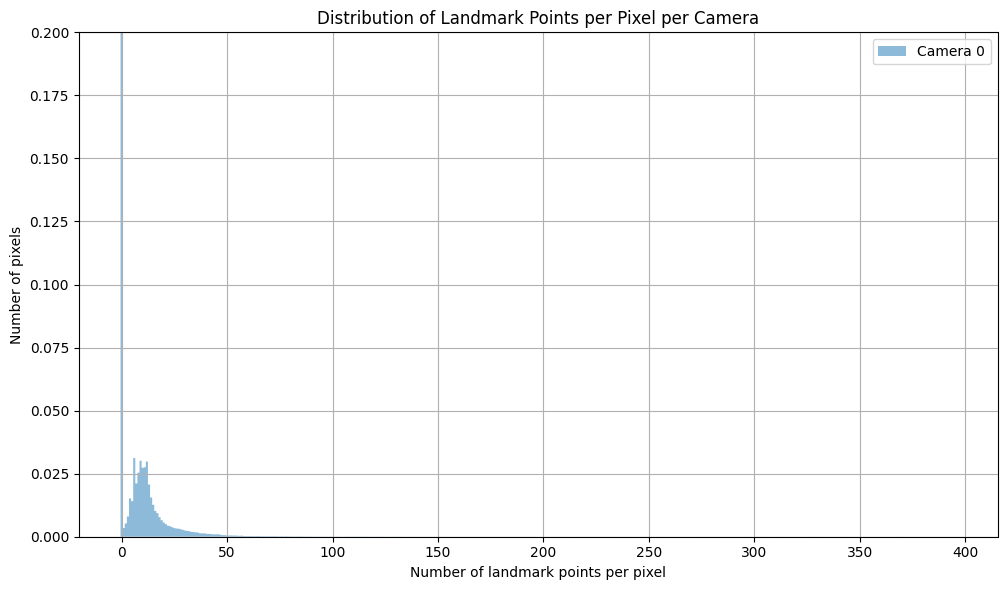

In [9]:
observations2 = courthouse_model.get_observations_Zbuffered(buffering_pixel_nb=(750,500), buffer_tolerance=0.02, show_lm_per_pixel_dist=[0])


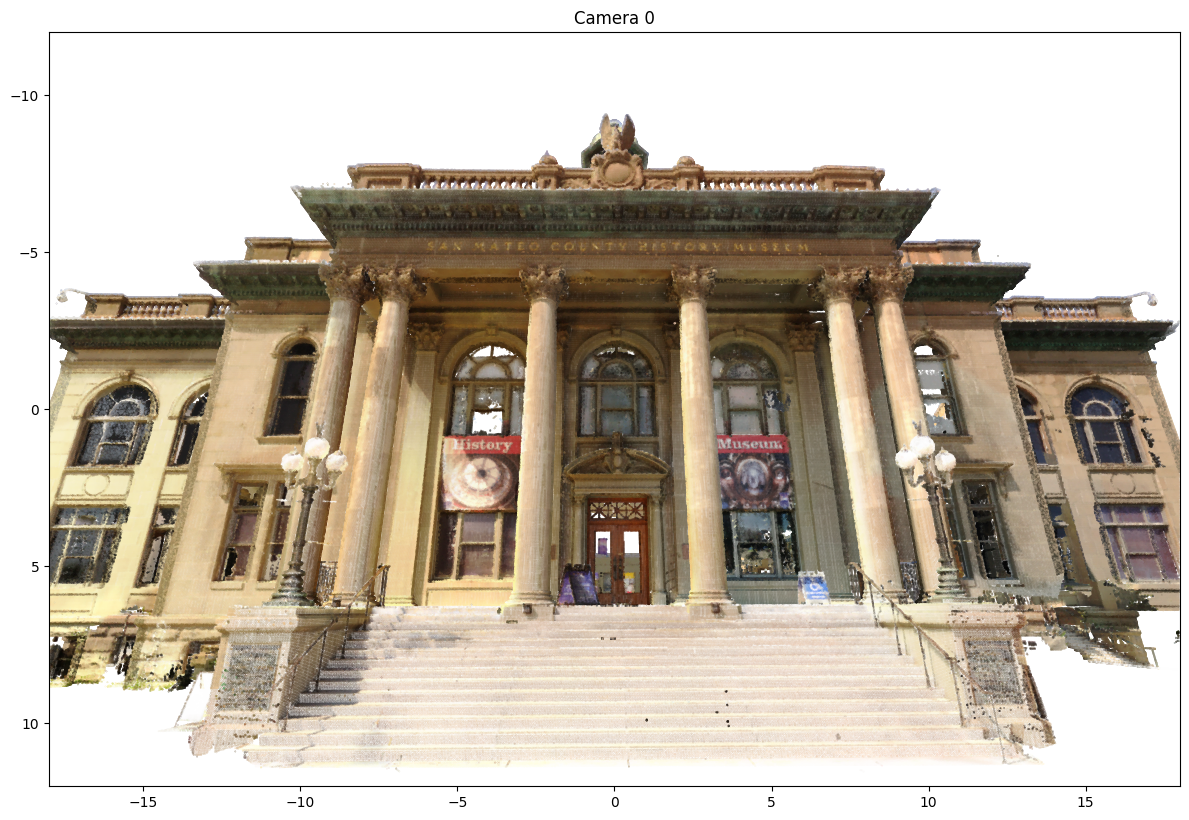

In [23]:
courthouse_model.visualize_projections(observations2,sphere_size=0.03, fig_size=12)

In [50]:
_ , _ , indices = downpcd.voxel_down_sample_and_trace(
    voxel_size=0.2,
    min_bound=downpcd.get_min_bound(),
    max_bound=downpcd.get_max_bound()
)

post_down_sampling_indices = [i[0] for i in indices if len(i) > 0]
print(len(indices))
downdownpcd = downpcd.select_by_index(post_down_sampling_indices)

downsampled_observations = observations2[:, post_down_sampling_indices, :]

cam_positions = np.array([cam_to_world])
landmarks = np.asarray(downdownpcd.points)
colors = downdownpcd.colors
ones = np.ones((landmarks.shape[0],1))
landmarks_homogeneous = np.hstack((landmarks, ones))
intrinsics = np.array([[18, 0, 0], [0, 18, 0], [0, 0, 1]], dtype=np.float64)

downsampled_courthouse_model = ToyModel(landmarks = landmarks_homogeneous, intrinsics=intrinsics, cam_to_world=cam_positions, colors=colors)

125414


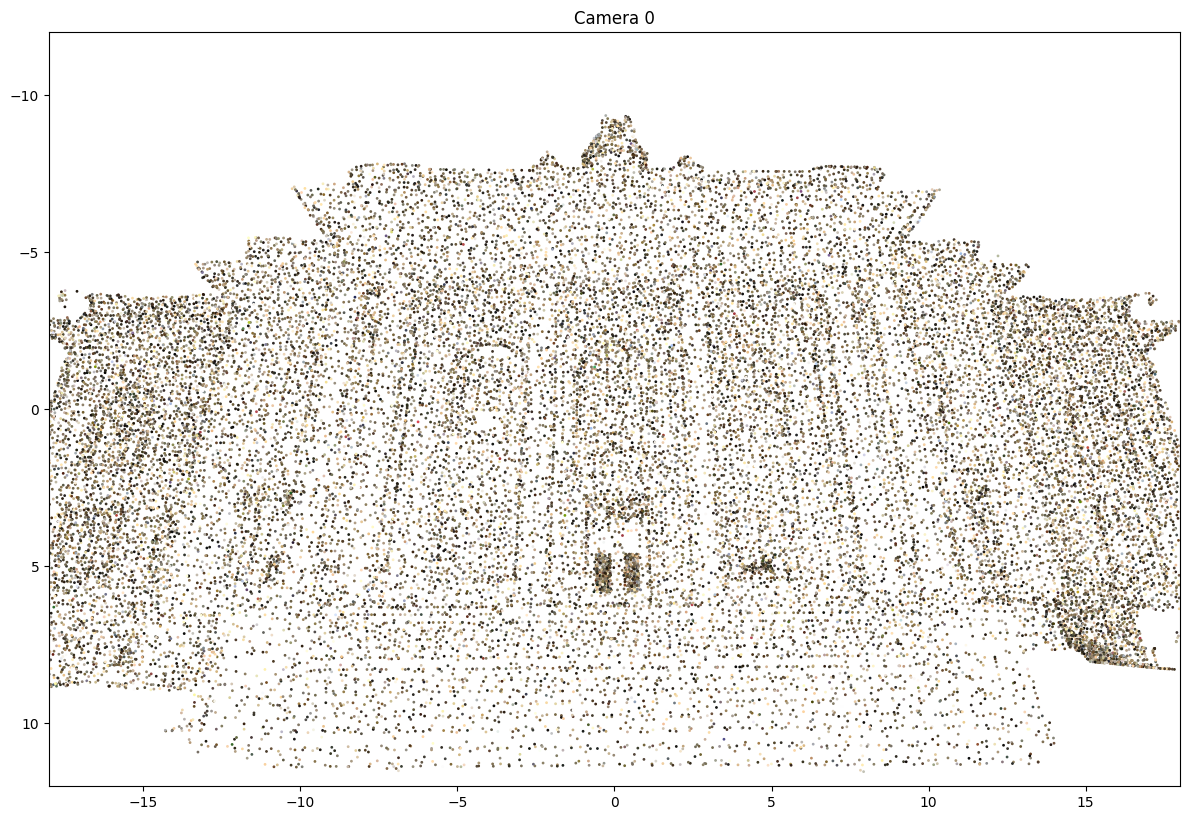

In [ ]:
downsampled_courthouse_model.visualize_projections(downsampled_observations, sphere_size=1, fig_size=12)

In [51]:

o3d.visualization.draw_geometries([downdownpcd])

In [15]:
_ , center_pose = get_visualiser_camera_parameters(downpcd)
_ , target_pose = get_visualiser_camera_parameters(downpcd)

Camera position and orientation (camera_to_world):
[[ 8.23346610e-01  8.61278589e-02  5.60965553e-01  2.06844979e+01]
 [-5.66551646e-01  1.83005074e-01  8.03447805e-01 -6.16531546e+01]
 [-3.34603032e-02 -9.79331984e-01  1.99472487e-01 -2.12227093e+01]]
Camera Intrinsic matrix:
[[935.30743609   0.         959.5       ]
 [  0.         935.30743609 539.5       ]
 [  0.           0.           1.        ]]
Camera position: [ 20.68449794 -61.65315457 -21.22270929]
Camera position and orientation (camera_to_world):
[[-8.62858653e-01 -1.52981240e-01 -4.81738191e-01  5.89735563e+01]
 [ 5.05132529e-01 -2.94520660e-01 -8.11232833e-01 -4.02334845e+00]
 [-1.77784454e-02 -9.43320900e-01  3.31405501e-01 -2.25964705e+01]]
Camera Intrinsic matrix:
[[935.30743609   0.         959.5       ]
 [  0.         935.30743609 539.5       ]
 [  0.           0.           1.        ]]
Camera position: [ 58.97355625  -4.02334845 -22.59647051]


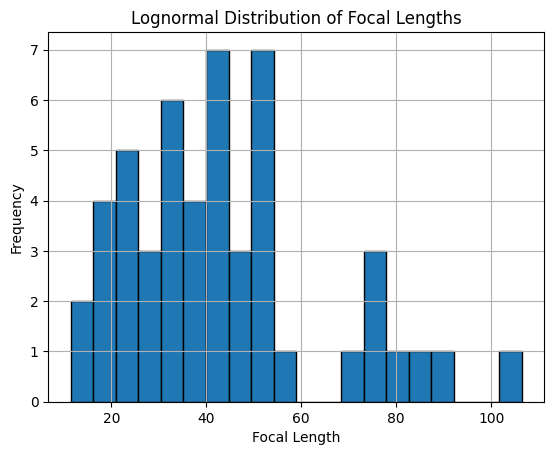

In [16]:
center_to_target = target_pose[:,3] - center_pose[:,3]
radius = np.linalg.norm(center_to_target)

cam_positions = camera_positions_arccircle(radial_range=np.pi / 2,
                                           radius = radius, cam_nb=50,
                                           center=center_pose[:,3], radial_offset=1,
                                           radius_noise_stddev=0.05,
                                           translation_noise_stddev=1,
                                           rotation_angle_noise_stddev=np.pi/25)
# intrinsics = np.array([[18, 0, 0], [0, 18, 0], [0, 0, 1]], dtype=np.float64)
intrinsics = lognormal_focal_length_generator(cam_nb=50, mean=3.7, sigma=0.6, show_distribution=True)

simplified_courthouse_model = ToyModel_From_PointCloud(pcd=downpcd, intrinsics=intrinsics, cam_to_world=cam_positions)
# downsampled_observations = simplified_courthouse_model.remove_occlusions_and_downsample(buffering_pixel_nb=(750,500), buffer_tolerance=0.02, voxel_size=0.2)
# simplified_courthouse_model.visualize_projections(downsampled_observations, sphere_size=1, fig_size=12)

simplified_courthouse_model.visualize_3D()

In [17]:
observations = simplified_courthouse_model.remove_occlusions_and_downsample(buffering_pixel_nb=(750,500), buffer_tolerance=0.02, voxel_size=0.02)

ToyDataset now contains {self.lm_nb} landmarks
Observations obtained after downsampling and hidden points removal stored in self.downsampled_observations


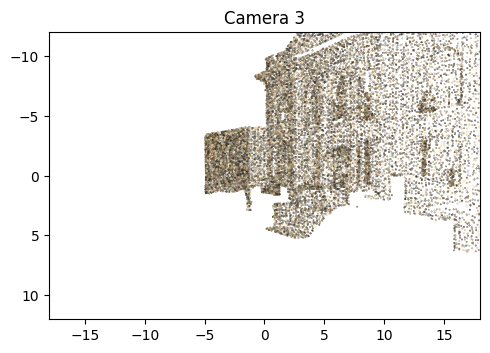

In [34]:
simplified_courthouse_model.visualize_projections(projections=observations, sphere_size=0.1, show_which_cam=[3])

In [24]:
simplified_courthouse_model.lm_nb * simplified_courthouse_model.cam_nb

6270700

In [25]:
observations.shape

(50, 125414, 2)

In [26]:
50 * 125414

6270700

In [ ]:
def save_to_NPZfile(self, filename):
    np.savez_compressed(
        filename,
        landmarks=self.landmarks,
        intrinsics=self.intrinsics,
        extrinsics=self.extrinsics,
        sensor_sizes=self.sensor_sizes,
        colors=self.colors if self.colors is not None else np.array([]),
        observations=self.observations if self.observations is not None else np.array([])
    )
    print(f"Saved ToyModel to {filename}")

In [24]:
mask = ~ np.isnan(observations2[0, :, 0])
points = np.asarray(downpcd.points)
colors = np.asarray(downpcd.colors)
selected_pcd = o3d.geometry.PointCloud()
selected_pcd.points = o3d.utility.Vector3dVector(points[mask])
selected_pcd.colors = o3d.utility.Vector3dVector(colors[mask])

non_selected_pcd = o3d.geometry.PointCloud()
non_selected_pcd.points = o3d.utility.Vector3dVector(points[~mask])
non_selected_pcd.colors = o3d.utility.Vector3dVector(colors[~mask])



o3d.visualization.draw_geometries([selected_pcd])
o3d.visualization.draw_geometries([non_selected_pcd])

o3d.visualization.draw_geometries([downpcd])


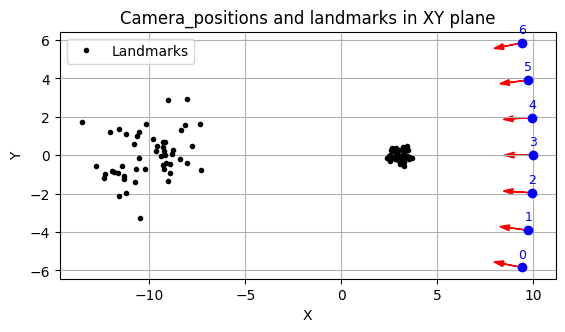

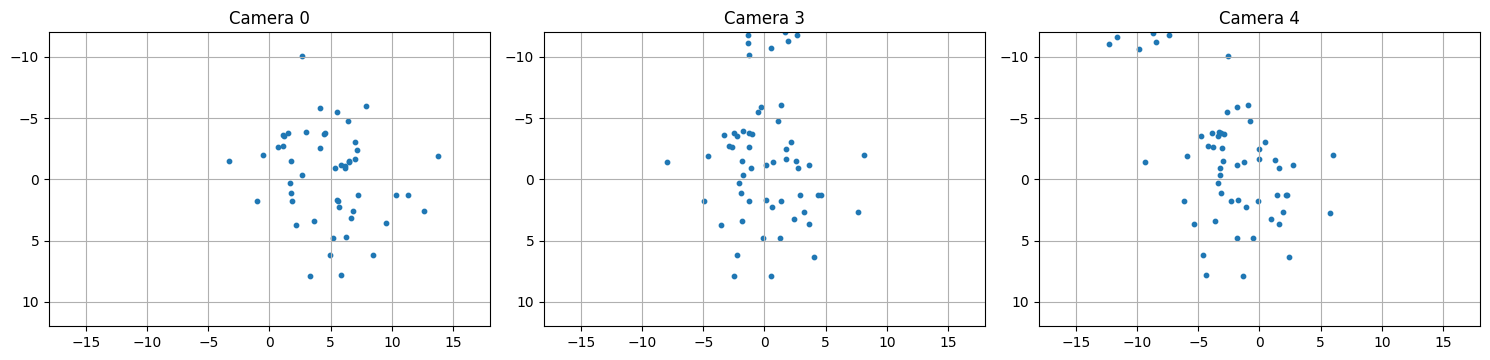

In [ ]:
#Enter landmark info
lm_nb = 50
lm_centers = [(3, 0, 2), (-10, 0, 0)]
lm_stddevs = [(0.3, 0.3, 0.3), (1.5, 1.5, 1.5)]

# Enter camera info
cam_nb = 7
cam_center = [-20, 0, 0]
cam_radius = 30
cam_radial_range = np.pi/8
focal_length = 50
principal_point = (0, 0)
sensor_size = (36, 24)
override_frame_constraints = True
in_frame=[]

path = '/Data/gautt/bundle_adjustment/robust_povar/data_custom/toydataset.txt'
Write = False

# Computations
intrinsics = np.array([[focal_length, 0, principal_point[0]], [0, focal_length, principal_point[1]], [0, 0, 1]])
cam_positions = camera_positions_arccircle(cam_radial_range, cam_radius, cam_nb, cam_center)
landmarks = gaussian_landmarks_homogeneous(lm_centers, lm_stddevs, lm_nb)
gaussian_toy_model2 = ToyModel(landmarks=landmarks, intrinsics=intrinsics, cam_to_world=cam_positions)
projections = gaussian_toy_model2.project_no_clipping()


# Visualizations
gaussian_toy_model2.visualize_cameras_2d(plane='xy', scale=1)
gaussian_toy_model2.visualize_projections(projections,show_which_cam=[0,3,4])


In [ ]:
# def read_coordinates(filename):
#     x, y, z = [], [], []
#     with open(filename, 'r') as file:
#         for line in file:
#             parts = line.strip().split()
#             if len(parts) == 3:
#                 xi, yi, zi = map(float, parts)
#                 x.append(xi)
#                 y.append(yi)
#                 z.append(zi)
#     return x, y, z

# def plot_coordinates(x, y, z):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(x, y, z, c='blue', marker='o')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.title("3D Point Cloud")
#     plt.show()

# file_path = '/Data/gautt/bundle_adjustment/robust_povar/output/landmarks.txt'
# x, y, z = read_coordinates(file_path)
# plot_coordinates(x, y, z)